# Timeline Analysis

This is the timeline clustering, statistical analysis etc. after finally completing data collection.

N.B. data path: /home/hubert/DPhil_Studies/2021-04_Study_A_Diffusion/collection_results_2021_06_19_16_21/data
user lists: /home/hubert/DPhil_Studies/2021-04_Study_A_Diffusion/collection_results_2021_06_19_16_21/user_list_full_0_nocount.txt


In [91]:
from bispec_clustering_eval import BSCresults
from timeline_analysis import TimelineAnalyzer
import numpy as np
import plotnine
import os
import pandas as pd
import datetime
import pickle
import re
import scipy.signal
import matplotlib.pyplot as plt
import glob
import tqdm
import jsonlines
from collections import Counter
from collections import defaultdict
import networkx as nx
from concurrent.futures import ProcessPoolExecutor, ThreadPoolExecutor


bscres = TimelineAnalyzer(
    '/home/hubert/DPhil_Studies/2021-04_Study_A_Diffusion/collection_results_2021_06_19_16_21/bsc', # data_dir
    '/home/hubert/DPhil_Studies/2021-04_Study_A_Diffusion/collection_results_2021_06_19_16_21/data',
)

In [96]:
# glob available timelines
timeline_flist = glob.glob('/home/hubert/DPhil_Studies/2021-04_Study_A_Diffusion/collection_results_2021_06_19_16_21/data/timeline*.jsonl')

# to collect the retweet edges, please use the get_user_timeline_rt_graph.py script
user_edges_pickle_file = '/home/hubert/DPhil_Studies/2021-04_Study_A_Diffusion/collection_results_2021_06_19_16_21/user_sets.obj'
if os.path.isfile(user_edges_pickle_file):
    with open(user_edges_pickle_file, 'rb') as f:
        user_edges = pickle.load(f)

assert type(user_edges) == defaultdict


## Print some Basic Graph Stats

In [3]:
with open('/home/hubert/DPhil_Studies/2021-04_Study_A_Diffusion/collection_results_2021_06_19_16_21/user_list_full_0_nocount.txt', 'r') as f:
    p = f.readlines()
    p = [int(i.replace('\n','')) for i in p]
    user_list = p

In [ ]:
# once get_user_timeline_rt_graph_sanity_check.py is run, read in the results and check. This is done externally with a .py file for multithreading. Once this is done once it doesn't really need to be done again. Therefore the sanity check flag.

sanity_check = True

if sanity_check:

    with open('/home/hubert/DPhil_Studies/2021-04_Study_A_Diffusion/collection_results_2021_06_19_16_21/user_sets_sanity_check.obj', 'rb') as f:
        results = pickle.load(f)

    not_in_user_list_keys = [i for i,v in results if i is not None]
    not_in_user_list_val  = []
    for i, v in results:
        for val in v:
            not_in_user_list_val.append(val)

    # really, not_in_user_list_keys should be empty.
    print('Length of not_in_user_list_keys should be 0 and this is {}',format(len(not_in_user_list_keys)==0))
    print('Length of not_in_user_list_val should be 0 and this is {}'.format(len(not_in_user_list_val)==0))

else:

    print('sanity check already complete')

In [62]:
# alternate graph construction

test_graph_2 = nx.DiGraph()

for i in user_edges.keys():
    assert int(i) in user_list

# assert len(user_list) == len(user_edges.keys())

user_edges_keys = user_edges.keys()

for k,v in tqdm.tqdm(user_edges.items()):

    # add k
    test_graph_2.add_node(str(k))

    v_counter = Counter(v)
    v_edge_list = [(str(k), str(node), count) for node,count in v_counter.items() if str(node) in user_edges_keys]

    test_graph_2.add_weighted_edges_from(v_edge_list)

# this works.

100%|██████████| 3022/3022 [00:03<00:00, 892.02it/s]


In [63]:
# once sanity check is complete, create graph.

# G = nx.graph(user_edges)
G = test_graph_2

print('Some Basic Stats: \n')
print('Number of nodes: {}'.format(len(G.nodes())))
print('Number of edges: {}'.format(len(G.edges())))
G_connected_components = nx.connected_components(G.to_undirected())
print('Number of connected components: {}'.format(len(list(G_connected_components))))

Some Basic Stats: 

Number of nodes: 3022
Number of edges: 80066
Number of connected components: 311


In [65]:
pos = nx.spring_layout(G)

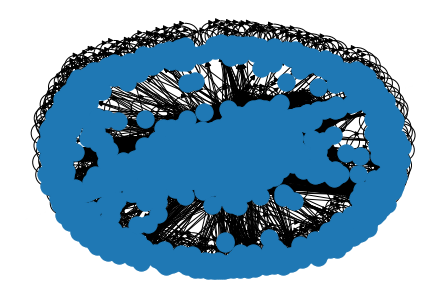

In [66]:
nx.draw(G, pos)

## Obtain Descriptive Stats for Users Collected

In [92]:
# first, how many users are incomplete?

# read in selected date ranges.
with open('/home/hubert/DPhil_Studies/2021-04_Study_A_Diffusion/collection_results_2021_06_19_16_21/selected_date_ranges.obj', 'rb') as f:
    selected_date_ranges = pickle.load(f)

# read in existing timeline completeness file
timeline_completeness_pickle_fname = '/home/hubert/DPhil_Studies/2021-04_Study_A_Diffusion/collection_results_2021_06_19_16_21/timeline_completeness.obj'

if os.path.isfile(timeline_completeness_pickle_fname):
    with open(timeline_completeness_pickle_fname, 'rb') as f:
        timeline_completeness = pickle.load(f)


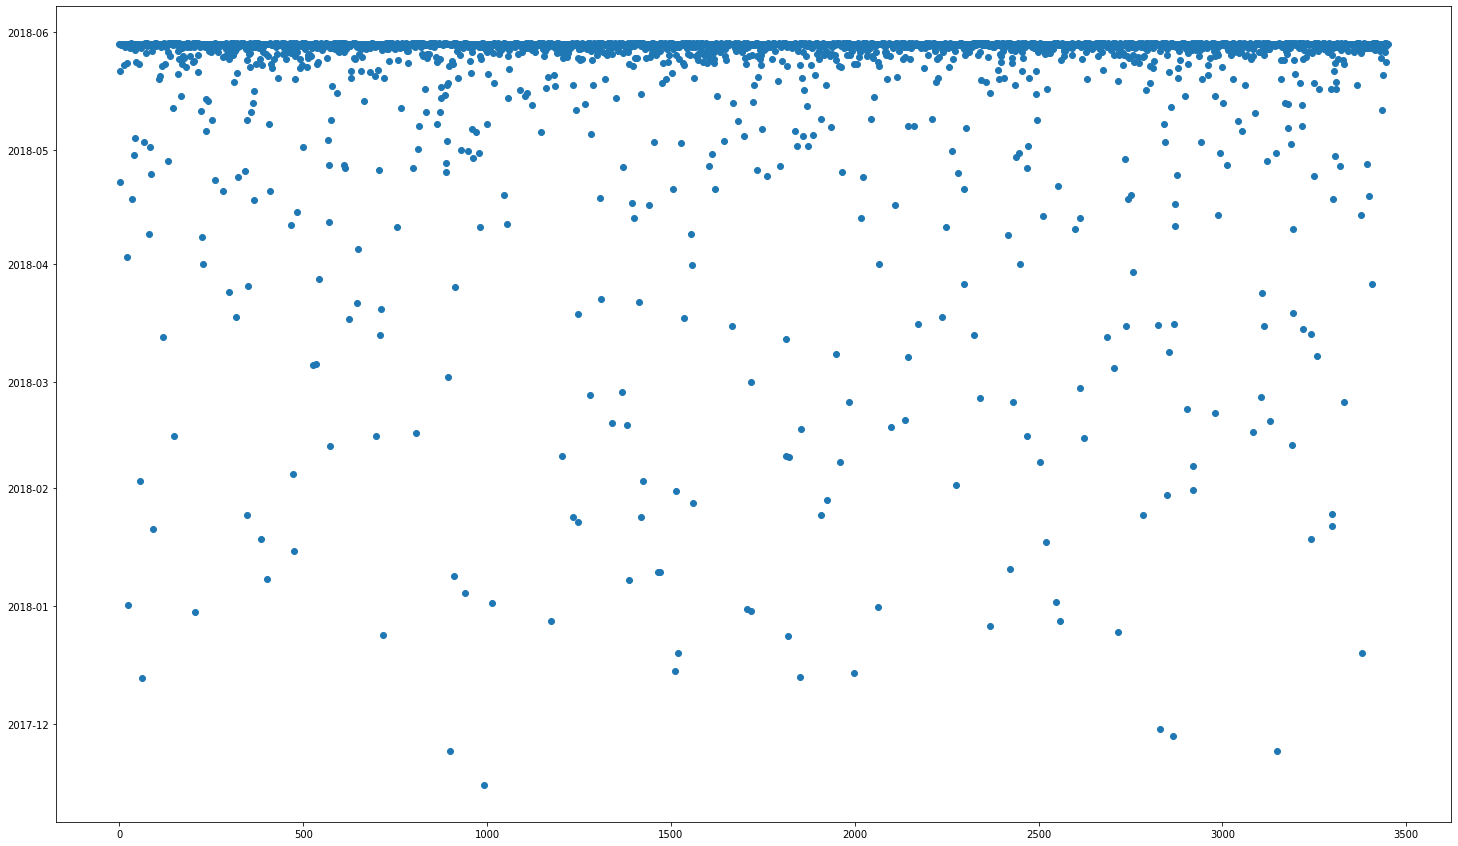

In [93]:
# simple scatter plot to seee which ones are not compelte
f = plt.figure(figsize=(25,15))
plt.scatter(range(len(timeline_completeness)), [i[1] for i in timeline_completeness])

In [94]:
pd.DataFrame([i[1] for i in timeline_completeness]).describe(datetime_is_numeric=True)

,0
count,3450
mean,2018-05-22 20:31:56.370434816
min,2017-11-15 00:00:00
25%,2018-05-27 21:46:32.249999872
50%,2018-05-28 18:37:40
75%,2018-05-28 22:51:31.750000128
max,2018-05-28 23:59:57


In [108]:
# percentages of each user timelines (both rt/qt and original tweets) that are of the searched hashtags

with open('/home/hubert/DPhil_Studies/2021-04_Study_A_Diffusion/search_hashtags.txt', 'r') as f:
    search_hashtags = f.readlines()
    search_hashtags = [i.replace('\n', '') for i in search_hashtags]
    search_hashtags = [i.replace('#', '') for i in search_hashtags]

user_percentage_results = []
for twitter_user_timeline in tqdm.tqdm(timeline_flist):

    with jsonlines.open(twitter_user_timeline) as reader:
        user_count = 0
        user_hash_count = 0
        for line in reader:
            tweets = line['data']
            for tweet in tweets:
                user_count += 1
                if 'entities' in tweet:
                    if 'hashtags' in tweet['entities']:
                        for i in tweet['entities']['hashtags']:
                            if i in search_hashtags:
                                user_hash_count += 1
    user_percentage_results.append((
        os.path.split(twitter_user_timeline)[1],
        user_hash_count,
        user_count,
        user_hash_count/user_count
    ))

  0%|          | 8/4344 [00:03<30:01,  2.41it/s]